In [1]:
import re
import os

import glob

import spacy
from spacy import displacy

import pandas as pd
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx
from pyvis.network import Network
import community as community_louvain

In [2]:
! python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:

# Setting plot styles

plt.style.use(['fivethirtyeight'])

In [4]:
# Creating directories for storing files

os.makedirs('src/htmls', exist_ok = True)
os.makedirs('src/plots', exist_ok = True)
os.makedirs('src/char_imp', exist_ok = True)
os.makedirs('data/gephi_files', exist_ok = True)

In [5]:
character_df1 = pd.read_csv('data/character_df1_cleaned.csv')
character_df1.head()

Season        Characters
0  Season_1      Jimmy McGill
1  Season_1  Mike Ehrmantraut
2  Season_1        Kim Wexler
3  Season_1     Howard Hamlin
4  Season_1       Nacho Varga

In [6]:
# Loading spaCy English language model

NER = spacy.load('en_core_web_sm')

In [7]:
# Reading season summary file

with open('data/summaries/Season_1.txt', 'r') as f:
    sea1_txt = f.read()
    
sea1_txt = sea1_txt.replace('\n', '\n. ')

In [8]:
# https://stackoverflow.com/a/51219483
# https://nanonets.com/blog/named-entity-recognition-with-nltk-and-spacy/ : For NLTK

ner1 = NER(sea1_txt)

# Visualize the identidied entites

displacy.render(ner1[:500], style = 'ent', jupyter = True)

In [9]:
# Looping through the sentences to create entity list and dataframe

entity_df = []

for sentence in ner1.sents:
    entity_lis = [ent.text for ent in sentence.ents]
    entity_df.append({'sentence' : sentence, 'entities' : entity_lis})
    
entity_df = pd.DataFrame(entity_df)
entity_df.head()

sentence  \
0  (In, a, black, and, white, flash, -, forward, ...   
1  (He, gets, nervous, when, a, customer, seems, ...   
2  (That, night, ,, inside, a, modest, house, ,, ...   
3  (The, tape, is, revealed, to, be, a, reel, of,...   
4  (As, the, ads, play, ,, ", Gene, ", begins, to...   

                                            entities  
0  [several months, Breaking Bad, Gene, Omaha, Ne...  
1                                                 []  
2                                        [Gene, VHS]  
3                               [Gene, Saul Goodman]  
4                                                 []

In [10]:
def remane_names(name):
    
    '''
    Changes name "Walter White Jr." to "Walt Jr."
    
    Input & Return :
      - string : name
    '''
    
    if name == 'Walter White Jr.':
        return re.sub(name, 'Walt Jr.', name)
    return name

In [11]:
# Extracting firstname and lastname and adding as new columns

character_df1.Characters = character_df1.Characters.apply(remane_names)
character_df1['Characters_firstname'] = character_df1.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[0]))
character_df1['Characters_lastname'] = character_df1.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[-1]))

character_df1.head()

Season        Characters Characters_firstname Characters_lastname
0  Season_1      Jimmy McGill                Jimmy              McGill
1  Season_1  Mike Ehrmantraut                 Mike         Ehrmantraut
2  Season_1        Kim Wexler                  Kim              Wexler
3  Season_1     Howard Hamlin               Howard              Hamlin
4  Season_1       Nacho Varga                Nacho               Varga

In [12]:
def filter_entities(entity_list, char_df):
    
    '''
    Takes a list as input and return a list if, the item in the entry list is present inside the
    pandas dataframe's columns 'Characters', 'Characters_firstname' and 'Characters_lastname'.
     
    Input :
      - list : entity_list
      - pandas dataframe : char_df
    Retuen :
      - list : 
    '''
    
    return [entity for entity in entity_list
            if entity in list(char_df.Characters)
            or entity in list(char_df.Characters_firstname)
            or entity in list(char_df.Characters_lastname)]

In [13]:
# Calling 'filter_entities()' to filter the entites only to character names from character_df

entity_df['char_entities'] = entity_df.entities.apply(lambda x: filter_entities(x, character_df1))
entity_df.head()

sentence  \
0  (In, a, black, and, white, flash, -, forward, ...   
1  (He, gets, nervous, when, a, customer, seems, ...   
2  (That, night, ,, inside, a, modest, house, ,, ...   
3  (The, tape, is, revealed, to, be, a, reel, of,...   
4  (As, the, ads, play, ,, ", Gene, ", begins, to...   

                                            entities char_entities  
0  [several months, Breaking Bad, Gene, Omaha, Ne...       [Omaha]  
1                                                 []            []  
2                                        [Gene, VHS]            []  
3                               [Gene, Saul Goodman]            []  
4                                                 []            []

In [14]:
# Filtering dataframe : Selecting only rows with atleast one entity

entity_df = entity_df[entity_df['char_entities'].map(len) > 0]
entity_df.reset_index(inplace = True, drop = True)
entity_df.head()

sentence  \
0  (In, a, black, and, white, flash, -, forward, ...   
1  (In, May, 2002, ,, Jimmy, McGill, is, a, down,...   
2  (After, he, fails, to, win, an, acquittal, for...   
3  (While, walking, to, his, dilapidated, car, ,,...   
4  (As, he, drives, away, from, the, courthouse, ...   

                                            entities  \
0  [several months, Breaking Bad, Gene, Omaha, Ne...   
1       [May 2002, Jimmy McGill, Albuquerque, three]   
2                                  [Jimmy, 700, 700]   
3                                   [Jimmy, British]   
4                                 [Mike Ehrmantraut]   

                 char_entities  
0                      [Omaha]  
1  [Jimmy McGill, Albuquerque]  
2                      [Jimmy]  
3                      [Jimmy]  
4           [Mike Ehrmantraut]

In [15]:
def name_correction(name):
    
    '''
    Takes input string and return a unique name based on the conditions.
    Names some times mentioned as first name, second name and some times
    as full name. This funtion helps to maintain unique name.
    Some identified names are included in this funtion, to make more robust,
    we can add more names and conditions here.
     
    Imput and Return :
      - string : name
    '''
    
    if name == 'Elliot' or name == 'Elliott Schwartz' or name == 'Schwartz':
        return 'Elliott'
    
    if name == 'Gretchen Schwartz':
        return 'Gretchen'
    
    if name == 'Gale' or name == 'Boetticher':
        return 'Gale Boetticher'
        
    if name == 'Gus' or name == 'Gustavo Fring' or name in "Gus'":
        return 'Gus Fring'
        
    if name == 'Saul' or name == 'Goodman':
        return 'Saul Goodman'
    
    if name == 'Schrader' or name == 'Hank Schrader':
        return 'Hank'
    
    if name == 'Jesse Pinkman' or name == 'Pinkman':
        return 'Jesse'
    
    if name == 'Mike Ehrmantraut' or name == 'Ehrmantraut':
        return 'Mike'
    
    if name == 'Walter White' or name == 'White' or name == 'Whites' or name == 'Walt':
        return 'Walter'
    
    if name == 'Skyler White':
        return 'Skyler'
    
    if name == 'Tuco':
        return 'Tuco Salamanca'

    if name == 'ASAC' or name == 'George Merkert':
        return 'ASAC George Merkert'

    if name == 'Donald':
        return 'Donald Margolis'
    
    if name == 'Jane':
        return 'Jane Margolis'

    if name == 'Hector':
        return 'Hector Salamanca'
    
    if name == 'APD':
        return 'DEA'
 
    if name == 'Ted' or name == 'Beneke':
        return 'Ted Beneke'
    
    if name in "Jimmy In-'N-Out":
        return 'Jimmy'

    if name == 'Andrea' or name == 'Cantillo':
        return 'Andrea Cantillo'
 
    if name == 'Leonel':
        return 'Leonel Salamanca'

    if name == 'Huell' or name == 'Babineaux':
        return 'Huell Babineaux'
 
    if name == 'Tyrus':
        return 'Tyrus Kitt'
    
    if name == 'Marie Schrader':
        return 'Marie'
 
    if name == 'Max' or name == 'Arciniega':
        return 'Max Arciniega'
    
    if name == 'Dennis':
        return 'Dennis Markowski'
    
    if name == 'Dan':
        return 'Dan Wachsberger'
    
    if name == 'Jack':
        return 'Jack Welker'
    
    if name == 'Todd':
        return 'Todd Alquist'
    
    if name in 'Lydia Rodarte-Quayle':
        return 'Lydia'
    
    if name == 'Peter':
        return 'Peter Schuler'    
    
    return name

In [16]:
relationship = []

for idx in range(entity_df.shape[0]):
    
    window_size = 5
    e_idx = min(idx+window_size, entity_df.shape[0])
    char_list = sum(entity_df.loc[idx:e_idx].char_entities, [])
    char_list = list(map(name_correction, char_list))
    
    # To remove same characters, if they are close to each other
    unique_char = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
    
    if idx % 220 == 0:
        print(char_list)
        print(unique_char)
        print('\n')

    if len(unique_char) > 1:
        for idx, a in enumerate(unique_char[:-1]):
            b = unique_char[idx + 1]
            relationship.append({'Source' : a, 'Destination' : b})

['Omaha', 'Jimmy McGill', 'Albuquerque', 'Jimmy', 'Jimmy', 'Mike', 'Loyola', 'Jimmy', 'Craig Kettleman', 'Jimmy']
['Omaha', 'Jimmy McGill', 'Albuquerque', 'Jimmy', 'Mike', 'Loyola', 'Jimmy', 'Craig Kettleman', 'Jimmy']


['Mike', 'Stacey', 'Hoffman', 'Fensky', 'Mike', 'Jimmy', 'Mike', 'Abbasi', 'Sanders', 'Jimmy', 'Abbasi', 'Mike']
['Mike', 'Stacey', 'Hoffman', 'Fensky', 'Mike', 'Jimmy', 'Mike', 'Abbasi', 'Sanders', 'Jimmy', 'Abbasi', 'Mike']


['Albuquerque', 'Chuck', 'Ernesto', 'HHM', 'Jimmy', 'Chuck', 'Chuck', 'Jimmy', 'Ernesto', 'Jimmy', 'HHM', 'Jimmy', 'Mike', 'Caldera', 'Jimmy', 'Mike']
['Albuquerque', 'Chuck', 'Ernesto', 'HHM', 'Jimmy', 'Chuck', 'Jimmy', 'Ernesto', 'Jimmy', 'HHM', 'Jimmy', 'Mike', 'Caldera', 'Jimmy', 'Mike']


['Mike', 'Fensky', 'Mike', 'Mike', 'Hoffman', 'Fensky', 'Mike', 'Mike', 'Fensky', 'Mike']
['Mike', 'Fensky', 'Mike', 'Hoffman', 'Fensky', 'Mike', 'Fensky', 'Mike']


['Marco', 'Jimmy', 'Jimmy', 'Marco', 'Jimmy', 'Jimmy', 'Marco', 'Jimmy', 'Marco', 'Jimmy',

In [17]:
relationship_df = pd.DataFrame(relationship)
print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")

relationship_df.head(20)

Shape of dataset 'relationship_df' :: (7377, 2)



Source      Destination
0             Omaha     Jimmy McGill
1      Jimmy McGill      Albuquerque
2       Albuquerque            Jimmy
3             Jimmy             Mike
4              Mike           Loyola
5            Loyola            Jimmy
6             Jimmy  Craig Kettleman
7   Craig Kettleman            Jimmy
8      Jimmy McGill      Albuquerque
9       Albuquerque            Jimmy
10            Jimmy             Mike
11             Mike           Loyola
12           Loyola            Jimmy
13            Jimmy  Craig Kettleman
14  Craig Kettleman            Jimmy
15            Jimmy            Craig
16            Craig            Betsy
17            Jimmy             Mike
18             Mike           Loyola
19           Loyola            Jimmy

In [18]:
# Calculating strength of the character bond

relationship_df['Weight'] = 1
relationship_df = relationship_df.groupby(['Source', 'Destination'], sort=False, as_index=False).sum()
relationship_df.head(10)

Source      Destination  Weight
0            Omaha     Jimmy McGill       6
1     Jimmy McGill      Albuquerque       8
2      Albuquerque            Jimmy       7
3            Jimmy             Mike     231
4             Mike           Loyola      10
5           Loyola            Jimmy      12
6            Jimmy  Craig Kettleman      12
7  Craig Kettleman            Jimmy      22
8            Jimmy            Craig      68
9            Craig            Betsy      34

In [19]:
import pandas as pd

# Assuming 'relationship_df' is your DataFrame.
# First, rename the columns
relationship_df.columns = ['Source', 'Target', 'Weight']

# Now, write the DataFrame to a CSV file.
relationship_df.to_csv('data/relationship_data1.csv', index=False)


In [20]:
# Creating graph from pandas dataframe

G = nx.from_pandas_edgelist(relationship_df, source = 'Source', target = 'Target', edge_attr = 'Weight', create_using = nx.Graph())

In [21]:
# node and edge count
print(f"total number of nodes: {len(G.nodes)}")
print(f"total number of edges: {len(G.edges)}")


total number of nodes: 56
total number of edges: 135


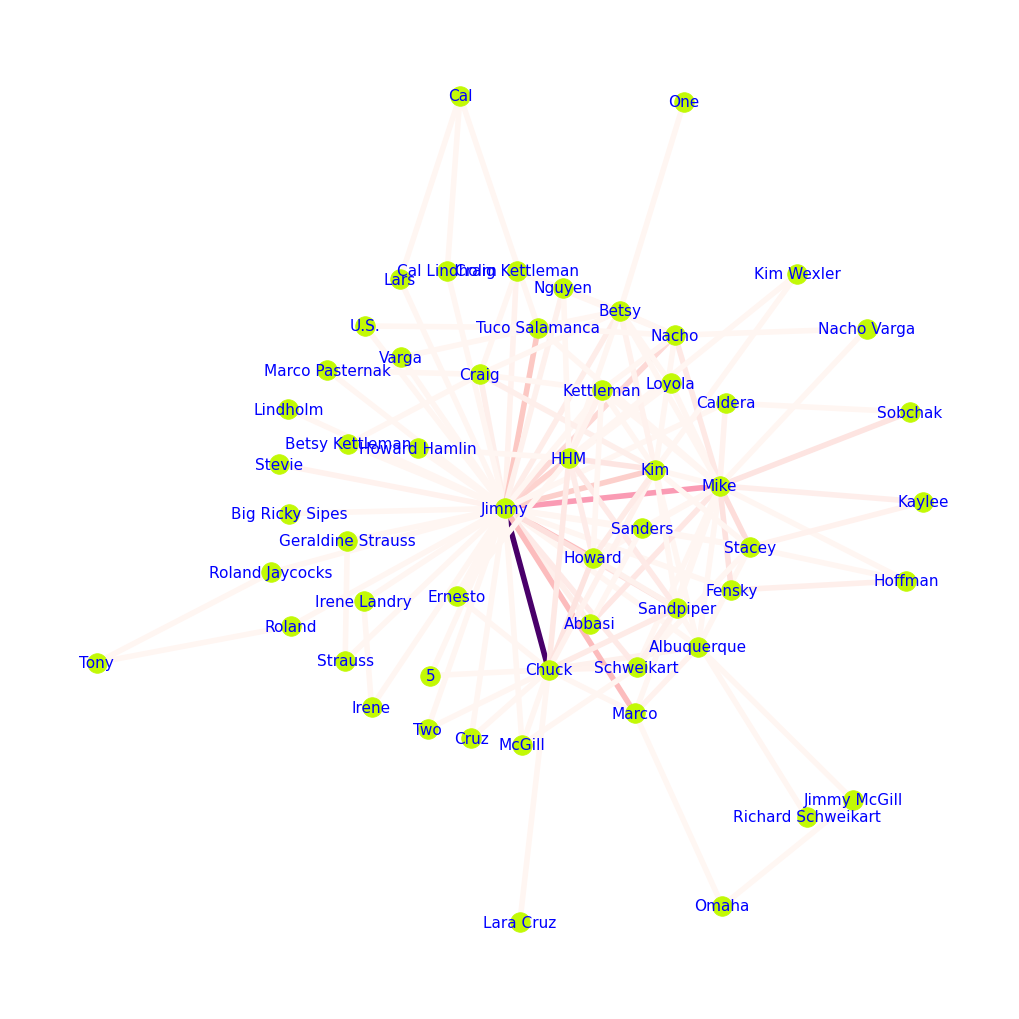

In [22]:
# https://stackoverflow.com/a/22971333
   
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)

Weights =  nx.get_edge_attributes(G, 'Weight').values()

arggs = {
        'with_labels' : 'True',
        'node_size' : 200,
        'node_color' : '#C2F906',
        'edge_color' : Weights, 
        "edge_cmap": plt.cm.RdPu,
        'width' : 4,
        'font_size' : 11,
        'font_color' : 'blue'
        }

nx.draw(G, pos = pos, **arggs)
plt.show()

In [64]:
# https://pyvis.readthedocs.io/en/latest/tutorial.html#example-visualizing-a-game-of-thrones-character-network

# net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#222222', font_color = 'white')
net = Network(notebook = True, width = '1300px', height = '950px', bgcolor = 'white', font_color = 'black')

node_degree = dict(G.degree)

# Setting node size
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
# net.save_graph('src/htmls/S01.html')
net.show('src/htmls/S01.html')

src/htmls/S01.html


In [24]:
from community import community_louvain

In [25]:
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'group')

print(f"Type of 'partition' :: {type(partition)}\n\n{partition}") 

Type of 'partition' :: <class 'dict'>

{'Omaha': 2, 'Jimmy McGill': 2, 'Albuquerque': 2, 'Jimmy': 1, 'Mike': 2, 'Loyola': 3, 'Craig Kettleman': 3, 'Craig': 3, 'Betsy': 3, 'Cal Lindholm': 1, 'Cal': 1, 'Lars': 1, 'HHM': 0, 'Howard Hamlin': 1, 'Chuck': 0, 'Howard': 0, 'Kim Wexler': 0, 'Kim': 0, 'Lindholm': 1, 'One': 3, 'Tuco Salamanca': 1, 'U.S.': 1, 'Varga': 1, 'Nguyen': 3, 'Nacho': 3, 'Kettleman': 0, 'Stevie': 1, 'Marco Pasternak': 3, 'Betsy Kettleman': 3, '5': 0, 'Two': 0, 'Big Ricky Sipes': 1, 'Roland Jaycocks': 1, 'Tony': 1, 'Roland': 1, 'Geraldine Strauss': 1, 'Strauss': 1, 'Lara Cruz': 0, 'Cruz': 0, 'Stacey': 2, 'Kaylee': 2, 'Caldera': 2, 'Abbasi': 2, 'Hoffman': 2, 'Fensky': 2, 'Sanders': 2, 'Irene Landry': 1, 'Irene': 1, 'Sandpiper': 0, 'Richard Schweikart': 0, 'Schweikart': 0, 'McGill': 0, 'Sobchak': 2, 'Nacho Varga': 3, 'Marco': 2, 'Ernesto': 0}


In [65]:
# net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#222222', font_color = 'white')
net = Network(notebook = True, width = '1300px', height = '950px', bgcolor = 'white', font_color = 'black',cdn_resources='remote')

net.from_nx(G, )
# net.save_graph('src/htmls/S01_Communities.html')
net.show('src/htmls/S01_Communities.html')

src/htmls/S01_Communities.html


In [67]:
def generate_spacy_tokens(filename):
    
    '''
    Takes file name as input and return a spaCy NER object
    
    To see first 500 words as NER, comment out the code.
     
    Input : 
      - string : filename of the summary file
    Return :
      - spaCy NER object
    '''
    
    with open(filename, 'r') as f:
        summary = f.read()
        
    summary = summary.replace('\n', '\n. ')
    
    summary = NER(summary)
    
    # displacy.render(summary[:500], style = 'ent', jupyter = True)
    
    return summary

In [68]:
def generate_entity_datafrane(summary):
    
    '''
    This function extracts NER entities from spaCy summary text
    and return a pandas dataframe with columns as text and list of entities.
    
    To see first 5 rows of the returning dataframe, comment out the code.
    
    Input : 
      - string : spaCy summary file
    Return :
      - pandas dataframe : entity_df
    '''
    
    entity_df = []

    for sentence in summary.sents:
        entity_lis = [ent.text for ent in sentence.ents]
        entity_df.append({'sentence' : sentence, 'entities' : entity_lis})

    entity_df = pd.DataFrame(entity_df)
    
    # display(entity_df.head().style.set_caption('entity_df').set_table_styles(styles))
    
    return entity_df

In [69]:
def clean_entity_df(df, char_df):
    
    '''
    This funtion takes entity_df and character_df as input and filters the entity_df values based on character_df.
    Extracts only character names and stores in new column of entity_df.
    A pandas dataframe is returned where there is atleast one entry in the newly created column.
    
    To see first 5 rows of the returning dataframe, comment out the code.
    
    Input : 
      - pandas dataframe : entity_df
      - pandas dataframe : character_df
    Return :
      - pandas dataframe : processed entity_df
    '''
    
    df['char_entities'] = df.entities.apply(lambda x: filter_entities(x, char_df))
    df = df[df['char_entities'].map(len) > 0]
    df.reset_index(inplace = True, drop = True)
    
    # display(df.head().style.set_caption('cleaned entity_df').set_table_styles(styles))
    
    return df

In [70]:
def generate_relationships(df):
    
    '''
    This function takes entity_df as input and iterates through whole the rows.
    We are taking a window_size and listing all the entries in that window and stores it as 'char_list'.
    From this listed 'char_list' we generates relationship and stores it as 'relationship'.
    A pandas dataframe is generating using this 'relationship' and return.
    
    Example on generating relationships :
    -------------------------------------
    char_list   = ['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter', 'Walter']
    unique_char = ['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter']
    
    In this exapmle in 'char_list', item 5 & 6, are same. So skipping similar items like this.
    Otherwise considering 1st item as 'source' and 2nd item as 'destination'.
    
    Input : 
      - pandas dataframe : entity_df
    Return :
      - pandas dataframe : relationship_df
    '''
    
    relationship = []
    window_size  = 5
    
    for idx in range(df.shape[0]):
        e_idx = min(idx+window_size, df.shape[0])
        char_list = sum(df.loc[idx:e_idx].char_entities, [])

        char_list = list(map(name_correction, char_list))

        unique_char = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
        
        if len(unique_char) > 1:
            for idx, a in enumerate(unique_char[:-1]):
                b = unique_char[idx + 1]
                relationship.append({'Source' : a, 'Target' : b})
                
    return pd.DataFrame(relationship)

In [71]:
def generate_graph_weights(df):
    
    '''
    Takes the 'relationship_df' as input and using pandas groupby funtion to count
    the number of occurance and stores in it in new coulcoulm 'value' and return the same dataframe.
    This 'value' will help us in identifying importance of the edges.
    
    To see first 5 rows of the returning dataframe, comment out the code.
    
    Input : 
      - pandas dataframe : relationship_df
    Return :
      - pandas dataframe : processed relationship_df
    '''
    
    df['Weight'] = 1
    df = df.groupby(['Source', 'Target'], sort=False, as_index=False).sum()
    
    # display(df.head(10).style.set_caption('WT_relationship_df').set_table_styles(styles))
    
    return df

In [72]:
def generate_map(filename):
    
    '''
    Takes file name as input and processes functions,
        1. generate_spacy_tokens()
        2. generate_entity_datafrane()
        3. clean_entity_df()
        4. generate_relationships()
        5. generate_graph_weights()
        
    Using 'generate_graph_weights' functions creating a 'networkx' grapg object and returns it.
    
    To see first 5 rows of the 'relationship_df' dataframe, comment out the appropriate code.
    To see shape of 'relationship_df' dataframe, comment out the appropriate code.
    
    To see first 5 rows of the 'processed relationship_df' dataframe, comment out the appropriate code.
    To see shape of 'processed relationship_df' dataframe, comment out the appropriate code.
    
    Input : 
      - string : path to the summary file
    Return :
      - pandas dataframe : networkx graph object
    '''
    
    summary = generate_spacy_tokens(filename)
    
    entity_df = generate_entity_datafrane(summary)
    
    entity_df = clean_entity_df(entity_df, character_df1)
    
    relationship_df = generate_relationships(entity_df)
    
    # display(relationship_df.head(10).style.set_caption('relationship_df').set_table_styles(styles))
    
    # print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")
    
    relationship_df = generate_graph_weights(relationship_df)
    
    # display(relationship_df.head(10).style.set_caption('processed relationship_df').set_table_styles(styles))
    
    # print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")
    
    return nx.from_pandas_edgelist(relationship_df, source = 'Source', target = 'Target', edge_attr = 'Weight', create_using = nx.Graph())

In [90]:
def community_plot(graph_object, season):
    
    '''
    This function takes a graph object and season name as input.
    Using 'community_louvain' generates communites and using this ploting
    community network with the help of pyvis' module.
    
    Inputs :
      - networkx graph object : 
      - string : name of the season
    Returns :
      - Saves and shows the generated pyvis community network plot
    '''
    
    partition = community_louvain.best_partition(graph_object)
    
    nx.set_node_attributes(graph_object, partition, 'group')
    
    net = Network(notebook = True, width = '1300px', height = '950px', bgcolor = 'white', font_color = 'black')
    
    for node in net.nodes:
        node['font'] = {'size': 40}
    
    net.repulsion(node_distance = 200) # Helped to reduce the vibration of the nodes.
    
    net.from_nx(graph_object)
    
    return net.show(f'src/htmls/{season}_Communities.html')

In [91]:
# https://stackoverflow.com/a/10035974
# https://engineeringfordatascience.com/posts/matplotlib_subplots/

def plot_centrality(graph_object, season):
    
    '''
    This function takes a graph object and season name as input.
    Using different centrality measures, obtaining top 5 node characters
    and their centrality values to generate bar plot.
    
    Different Centrality measures we are using,
        1. Degree Centrality
        2. Closeness Centrality
        3. Betweenness Centrality
        4. EigenVector Centrality

    Inputs :
      - networkx graph object : 
      - string : name of the season
    Returns :
      - None : Only saves plots generated to mentioned dirctory
    '''
    
    nx_centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.eigenvector_centrality]
    centralities = ['Degree', 'Closeness', 'Betweenness', 'EigenVector']
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 16))
    plt.subplots_adjust(hspace = 0.3)
    
    fig.suptitle(f'{season} : Character importance', y = 0.95)
    
    axs = axs.ravel()
    
    for idx, (title, nx_graph) in enumerate(zip(centralities, nx_centralities)):
        
        top_5_chars = dict(sorted(nx_graph(graph_object).items(), key = lambda x : x[1], reverse = True)[:5])
        
        sns.barplot(x = list(top_5_chars.keys()), y = list(top_5_chars.values()), ax = axs[idx])
        
        axs[idx].set_title(f'Based on : {title} centrality')
        axs[idx].tick_params(axis = 'x', labelrotation = 10)
        
    plt.savefig(f'src/plots/{season}_char_imp.svg', bbox_inches = 'tight', pad_inches = 0.3)
    
    plt.show()

In [92]:
# Obtaining all the summary file path

summaries = sorted(glob.glob('data/summaries/Season*.txt'), reverse = False)

In [93]:
# For stylizing dataframes

styles = [dict(selector='caption', props=[('text-align', 'center'), ('font-size', '150%'), ('color', '#FFFFFF'), ('background-color' , '#6DA3C7')])] 

In [94]:
# Generating networkx's graph objects for all the summaries present

map_dict = {}

for season in summaries:
    key = season.split('/')[-1]
    key = season.split('\\')[-1]
    key = key.split('.')[0]
    # print(key)
    map_dict[key] = generate_map(season)
    
map_dict


{'Season_1': <networkx.classes.graph.Graph at 0x162c0bd6f90>,
 'Season_2': <networkx.classes.graph.Graph at 0x162c0d52590>,
 'Season_3': <networkx.classes.graph.Graph at 0x1628065cb50>,
 'Season_4': <networkx.classes.graph.Graph at 0x162c0bb5190>,
 'Season_5': <networkx.classes.graph.Graph at 0x162bfebc510>,
 'Season_6': <networkx.classes.graph.Graph at 0x162c0d3b810>}

In [95]:
community_plot(map_dict['Season_1'], 'Season_1')

src/htmls/Season_1_Communities.html


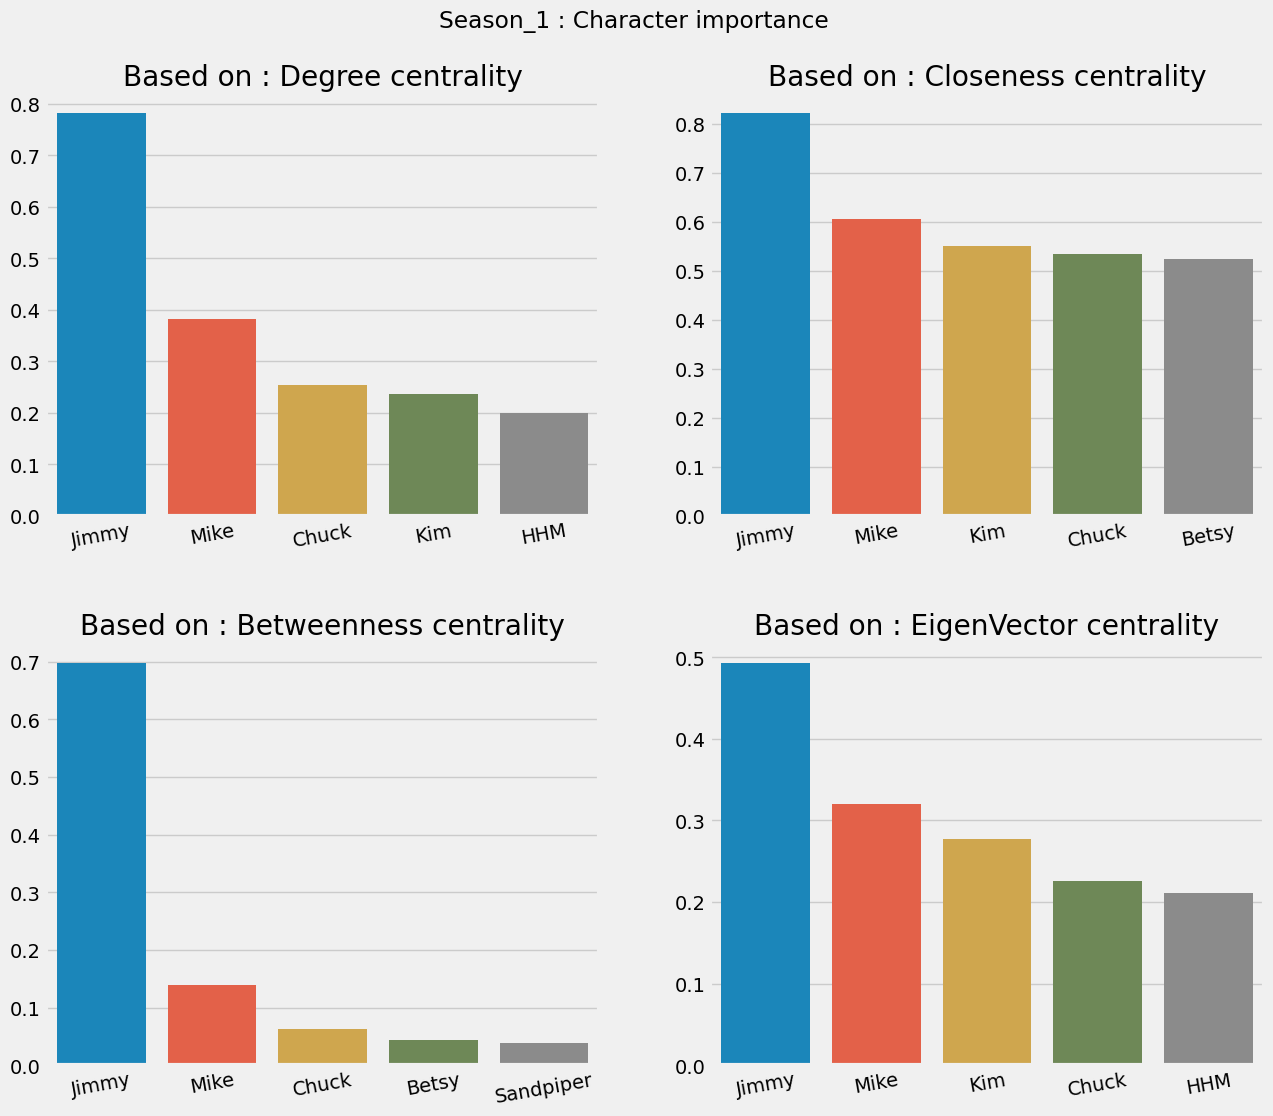

In [39]:
plot_centrality(map_dict['Season_1'], 'Season_1')

In [40]:
community_plot(map_dict['Season_2'], 'Season_2')

src/htmls/Season_2_Communities.html


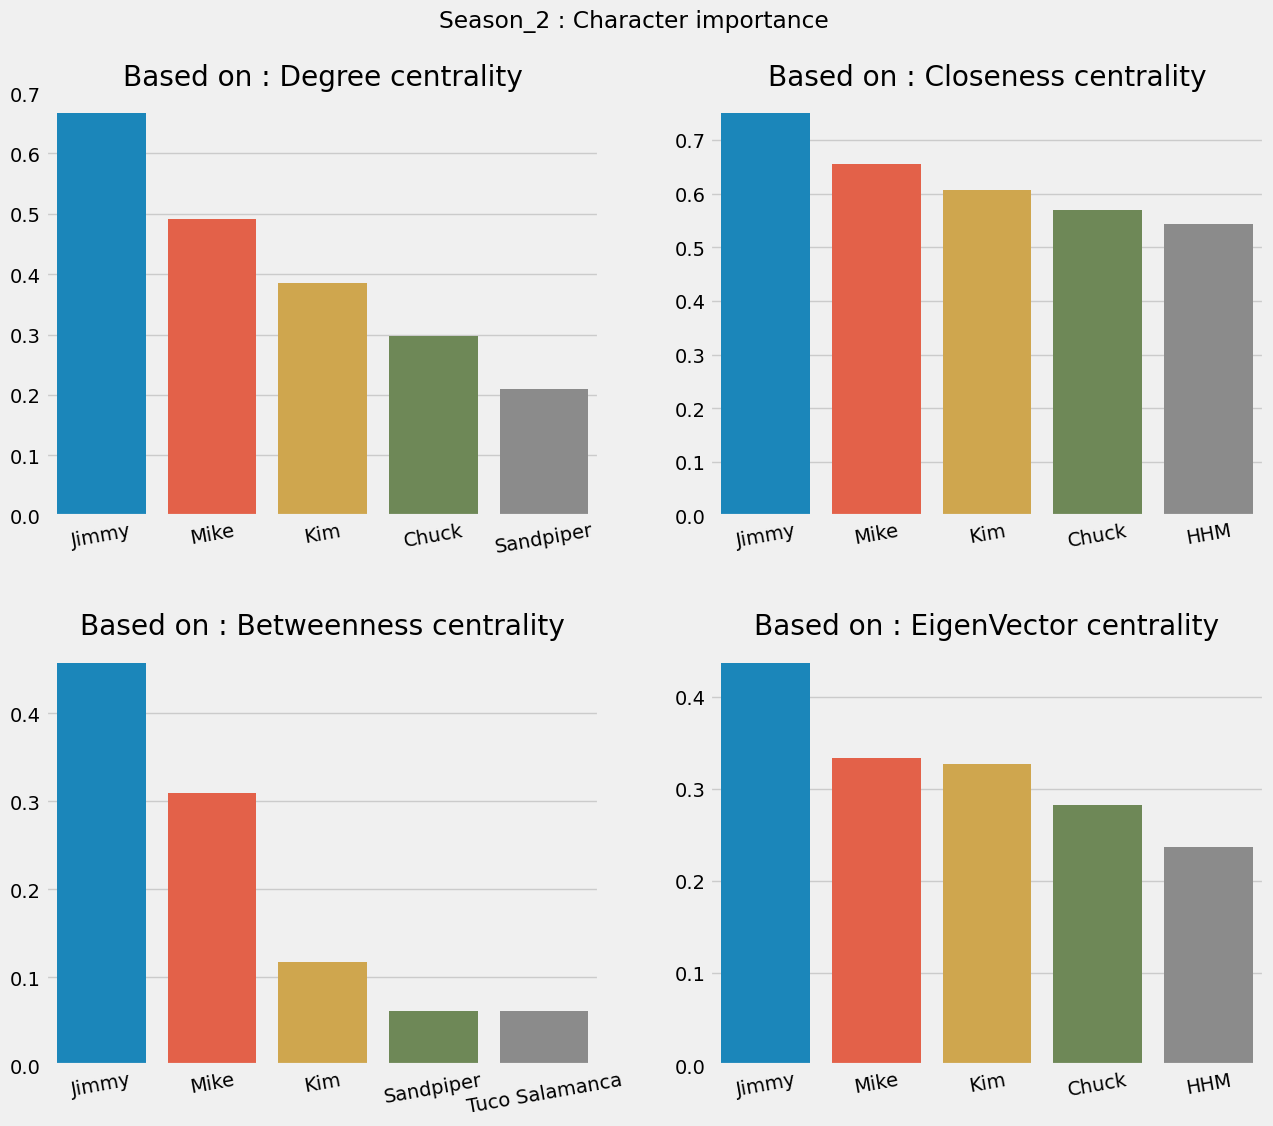

In [41]:
plot_centrality(map_dict['Season_2'], 'Season_2')

In [42]:
community_plot(map_dict['Season_3'], 'Season_3')

src/htmls/Season_3_Communities.html


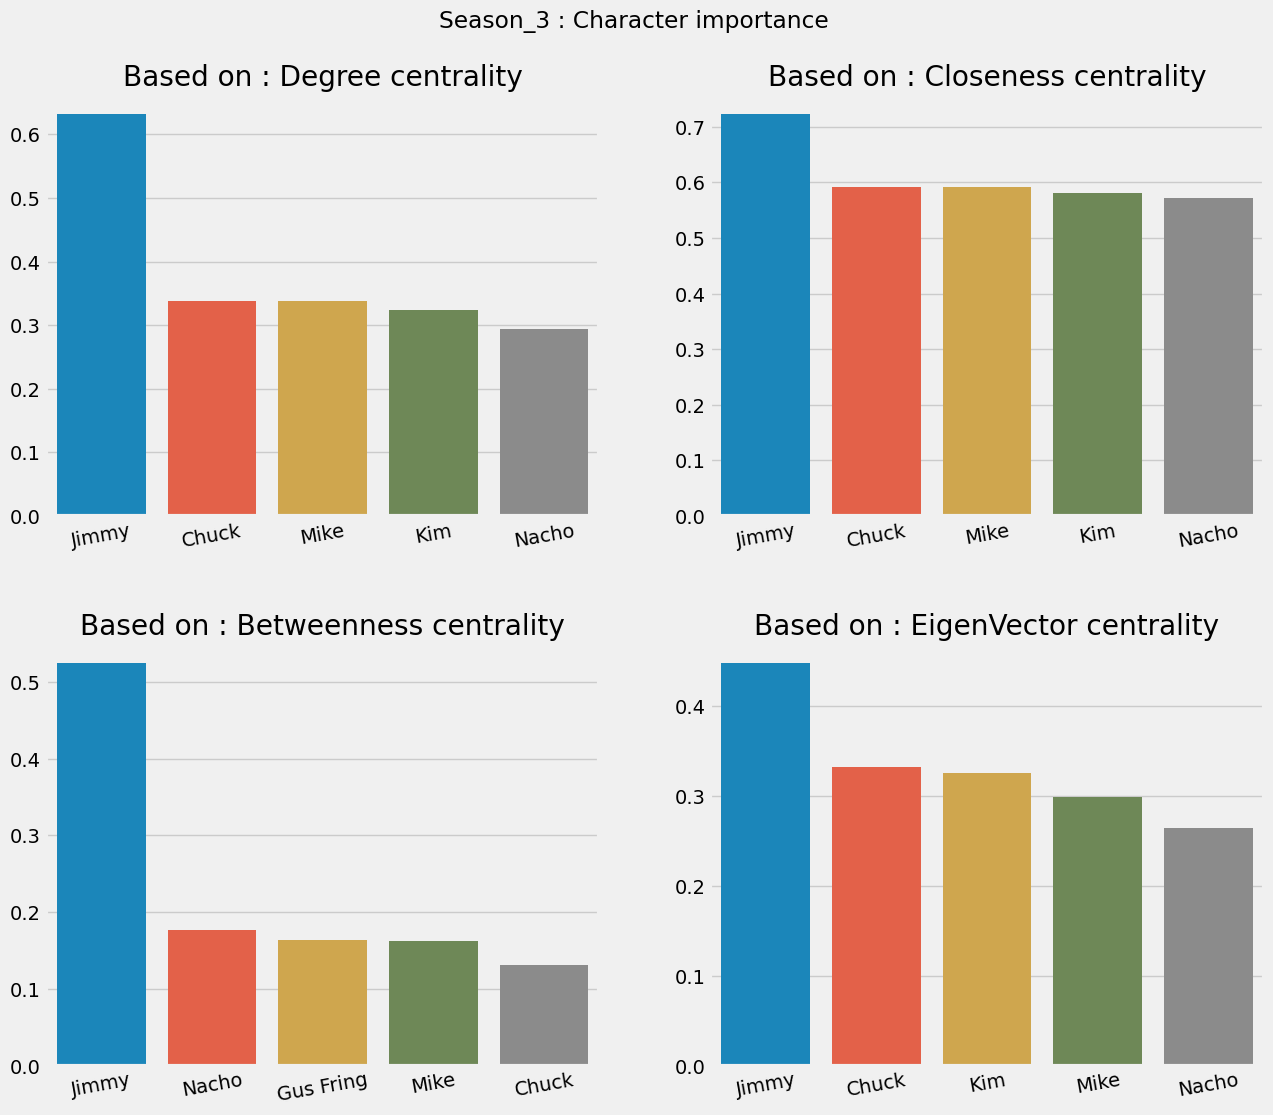

In [43]:
plot_centrality(map_dict['Season_3'], 'Season_3')

In [44]:
community_plot(map_dict['Season_4'], 'Season_4')

src/htmls/Season_4_Communities.html


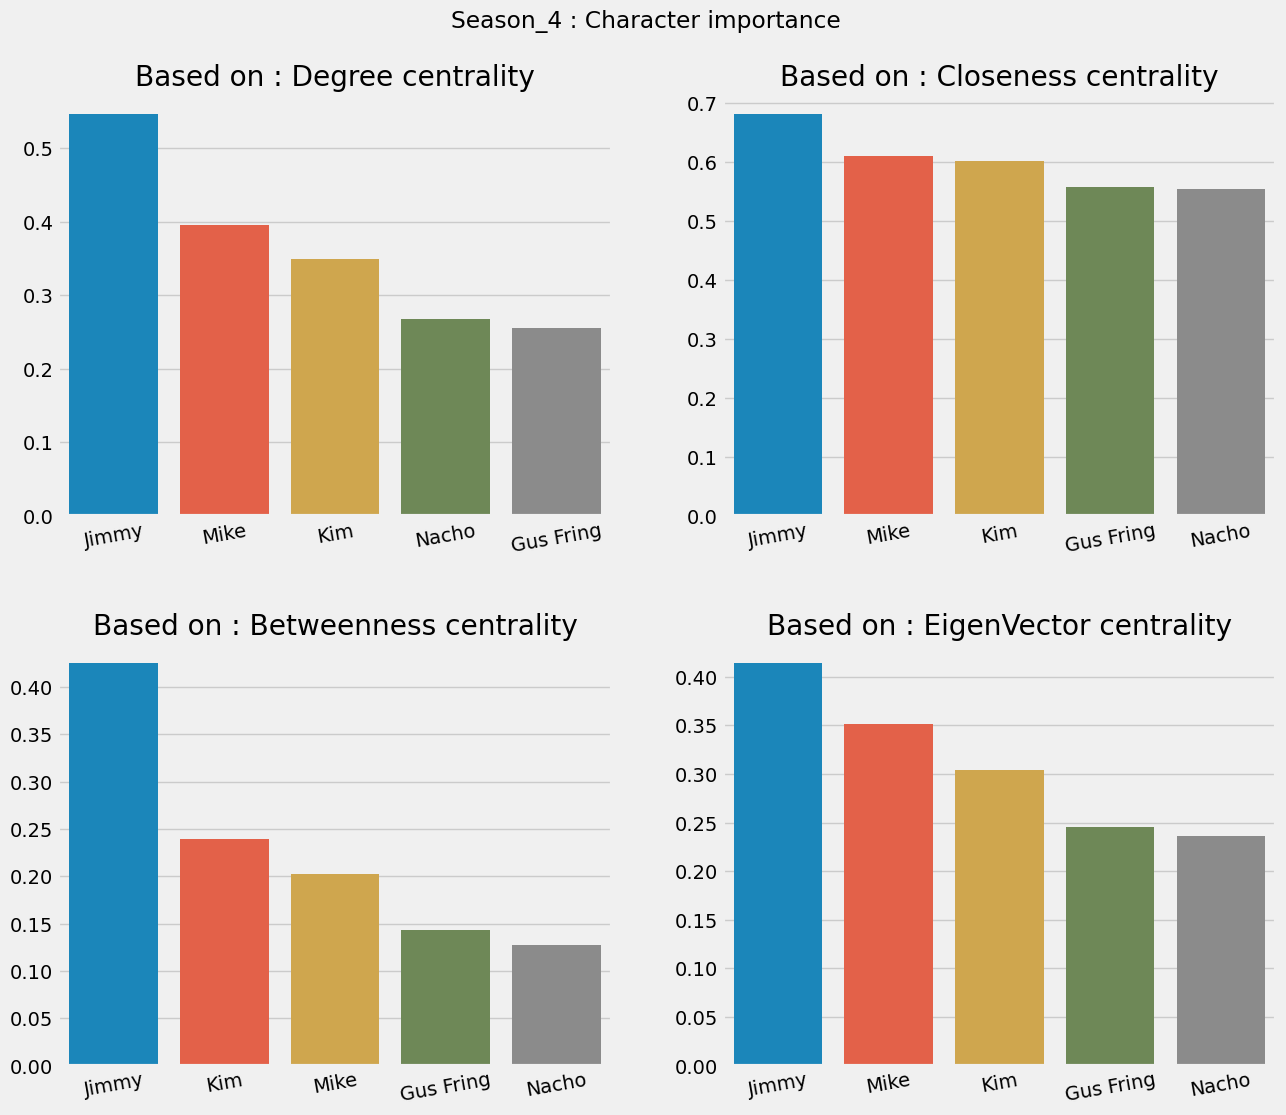

In [45]:
plot_centrality(map_dict['Season_4'], 'Season_4')

In [46]:
community_plot(map_dict['Season_5'], 'Season_5')

src/htmls/Season_5_Communities.html


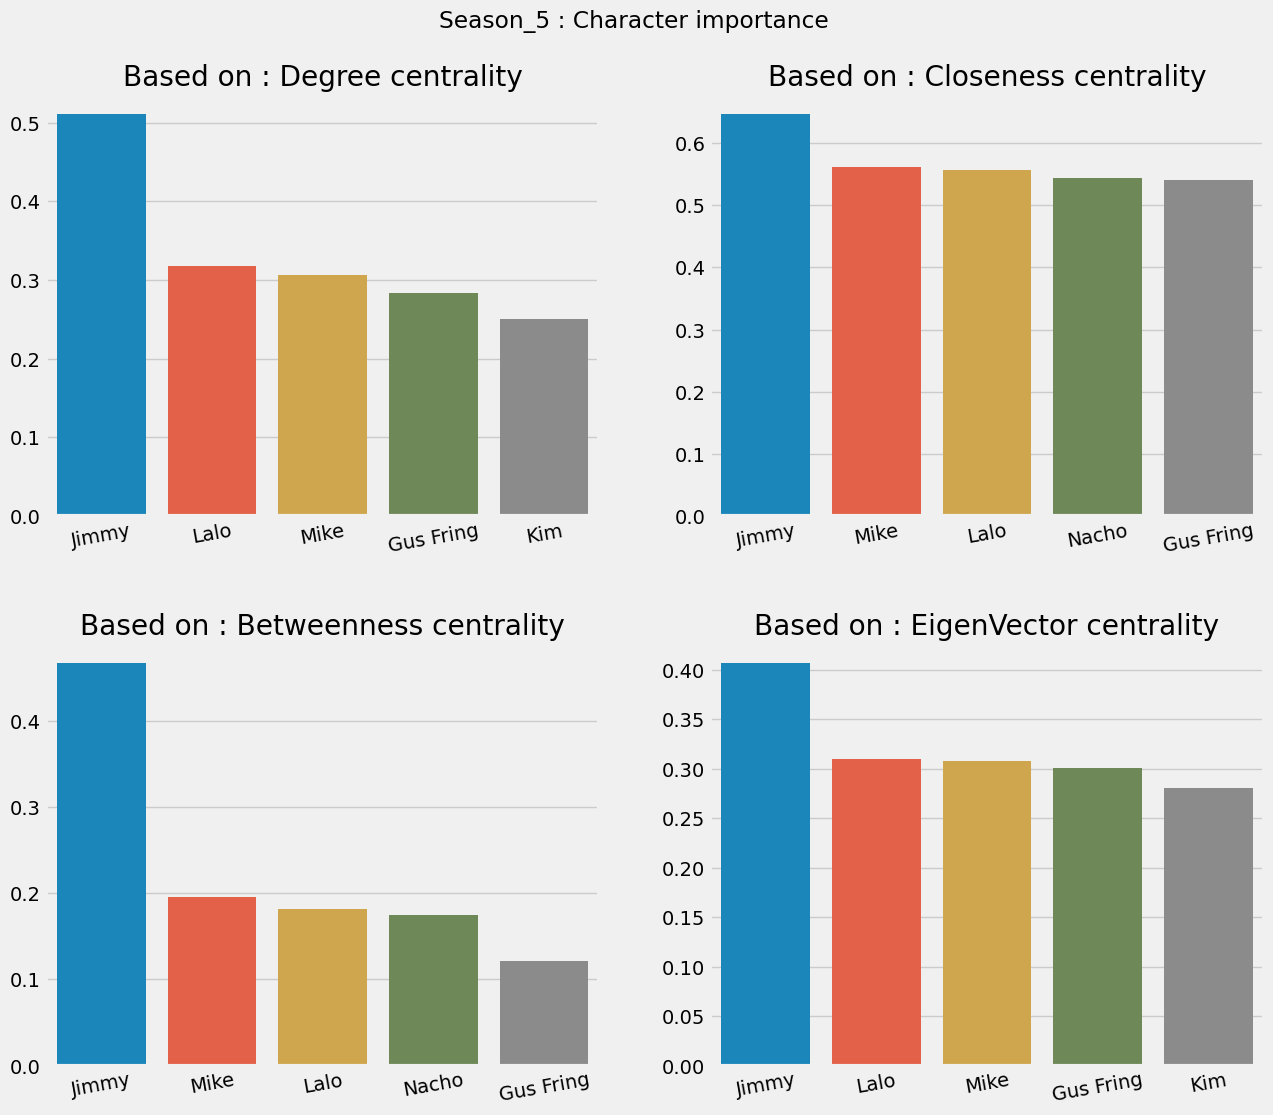

In [47]:
plot_centrality(map_dict['Season_5'], 'Season_5')

In [48]:
community_plot(map_dict['Season_6'], 'Season_6')

src/htmls/Season_6_Communities.html


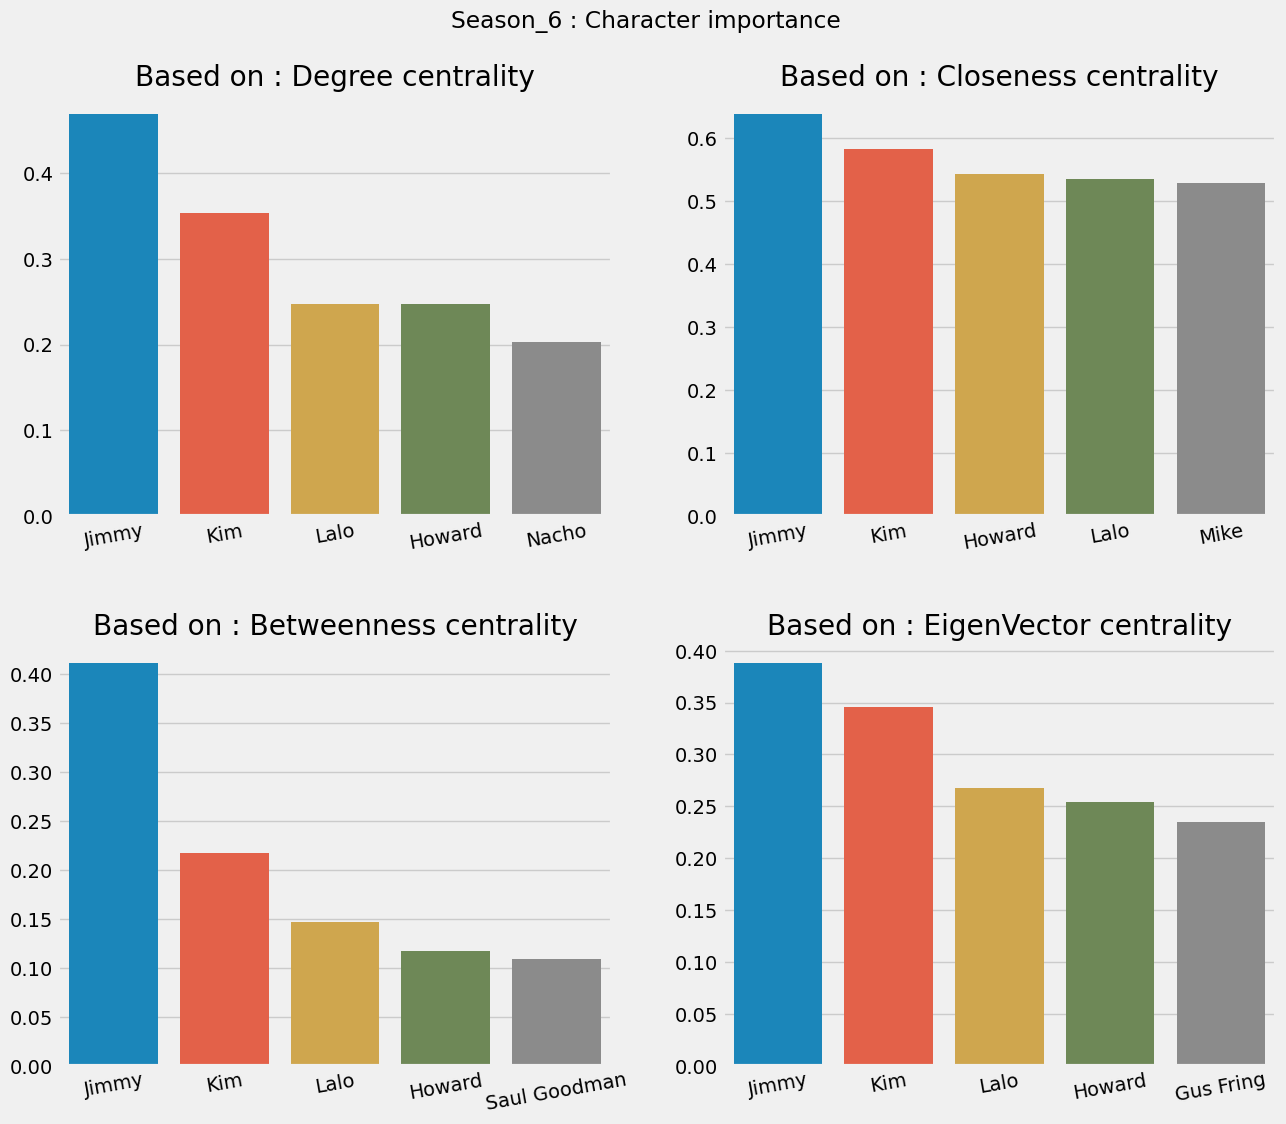

In [49]:
plot_centrality(map_dict['Season_6'], 'Season_6')

In [50]:
# Combining all the season wise summaries to one file

combined_summary_path = 'data/summaries/combined_summaries.txt'

with open(combined_summary_path, 'w') as combined:
    for season in summaries:
        with open(season, 'r') as summary:
            combined.writelines(summary.read())

In [51]:
# Generating graph object for combined text data file

combined_map = generate_map(combined_summary_path)

In [52]:
community_plot(combined_map, 'Combined')

src/htmls/Combined_Communities.html


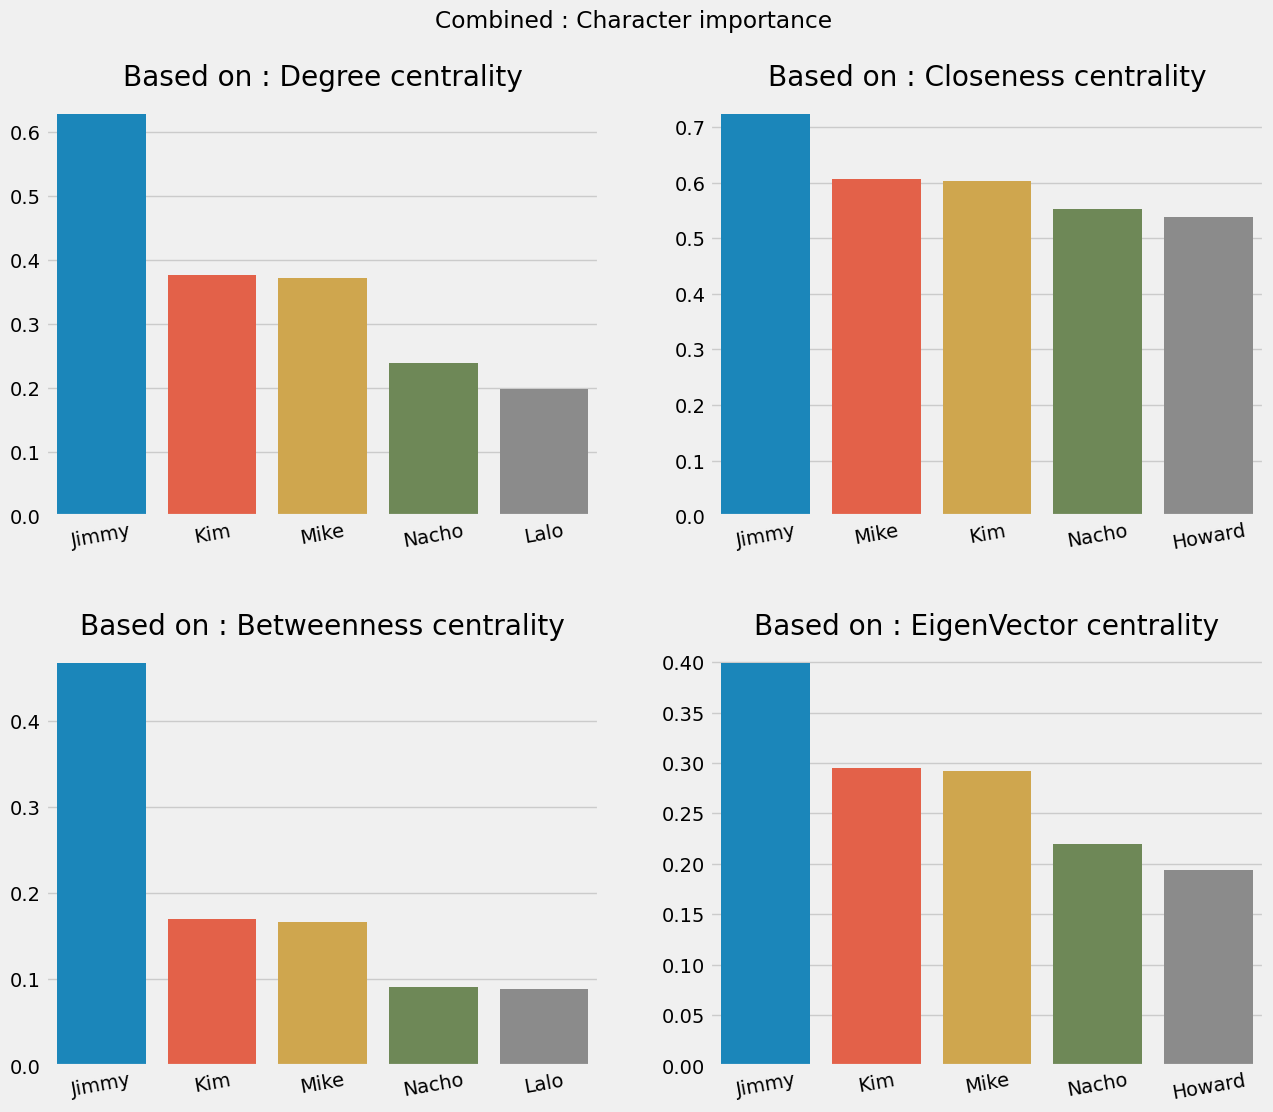

In [53]:
plot_centrality(combined_map, 'Combined')

In [54]:
# https://plotly.com/python/static-image-export/

def character_Importence(centrality, title_):
    
    '''
    Takes networkx centrality object function and a sting for plot title.
    Iterated through all the seasons networkx_graph object and generates centrality score, 
    on this takes top 5 node characters with the centrality scores.
    Using this record of 5 top nodes of each season ploting a line plot using 'Plotly' module.
    
    Input :
      - networkx centrality object : centrality
      - sting : title_
    Return :
      - None : Only plots the lineplot and saves it to the metioned directory.
    '''
    
    set_of_char = set()
    file_name = 'src/char_imp/' + title_ + '.svg'
    title_ = ' '.join(title_.split('_')).title()
    
    if title_ != 'betweenness_centrality' :
        evolution = [centrality(map_) for season, map_ in map_dict.items()]
    else:
        evolution = [centrality(map_, weight = 'Weight') for season, map_ in map_dict.items()]
    evolution_df  = pd.DataFrame(evolution)
    evolution_df.index = list(map_dict.keys())
    
    for idx in range(evolution_df.shape[0]):
        
         set_of_char.update(evolution_df.iloc[idx].sort_values(ascending = False)[:5].index) 
            
    set_of_char = list(set_of_char)

    evolution_df = pd.melt(evolution_df[set_of_char].reset_index().fillna(0), id_vars = 'index', var_name = 'Char_Name', value_name = 'Centrality_Score')
    
    fig = px.line(evolution_df, x = 'index', y = 'Centrality_Score', color = 'Char_Name', height = 500, width = 1000, labels = {'Centrality_Score' : f'{title_} Score', 'index' : ''})
    fig.update_layout(
        {'title' : 
             {'text' : f'Character Importance : {title_}', 'x' : 0.5},
         'hovermode' : 'x'
         # 'hovermode' : 'x unified' # For different style hover data information
        })
    fig.update_traces(
        {'mode' : 'markers + lines',
         'hovertemplate' : None
        })
    
    fig.write_image(file_name)
    fig.show()

In [55]:
character_Importence(nx.closeness_centrality, 'closeness_centrality')

In [56]:
character_Importence(nx.betweenness_centrality, 'betweenness_centrality')

In [57]:
character_Importence(nx.eigenvector_centrality, 'eigenvector_centrality')

In [58]:
character_Importence(nx.pagerank, 'pagerank')

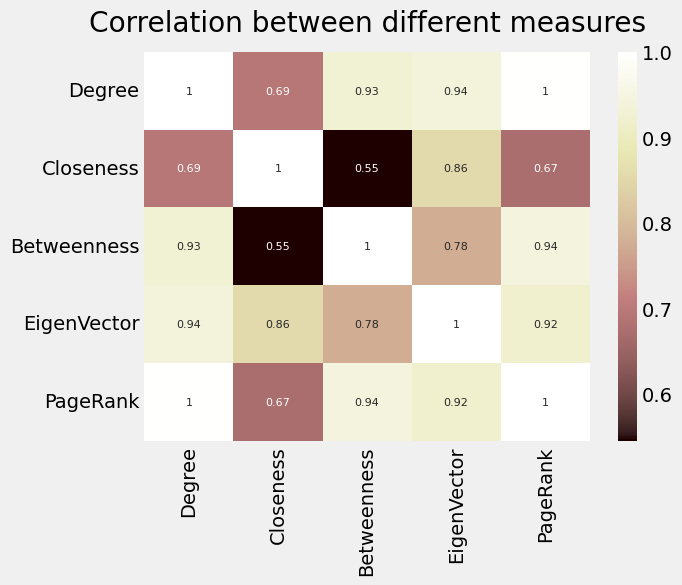

In [59]:
# https://stackoverflow.com/a/56243909

all_measures = [nx.degree_centrality(combined_map), nx.closeness_centrality(combined_map), nx.betweenness_centrality(combined_map, weight='weight'), nx.eigenvector_centrality(combined_map), nx.pagerank(combined_map)]
idx_name = ['Degree', 'Closeness', 'Betweenness', 'EigenVector', 'PageRank']

cor = pd.DataFrame(all_measures)
cor.index = idx_name
sns.heatmap(cor.T.corr(), annot = True, annot_kws = {'size' : 8}, cmap = plt.get_cmap('pink')) # pink, afmhot
plt.title('Correlation between different measures', pad = 15)
plt.show()

In [60]:
def csv_for_gephi(graph_obj, name_):
    
    '''
    Gephi is a open-source network visualization tool. To work with Gephi, we can use CSV files.
    Using networkx's 'to_pandas_edgelist' funtion we can extract all the present graph graph infromations.
    Combining this with 'graph's' node data we will have enough data for our Gephi needs.
    
    Input :
      - networkx graph object :graph_obj
      - string : name_
    Return :
      - None : Only saves CSV files at it's desired loactions
    '''
    
    edge_list_df = nx.to_pandas_edgelist(graph_obj).rename(columns = {'value' : 'weight'}).drop('width', axis = 1)
    node_df = pd.DataFrame(dict(graph_obj.nodes)).T.reset_index().rename(columns = {'index' : 'source'}).drop('size', axis = 1)
    final_df = pd.merge(edge_list_df, node_df, on = 'source').rename(columns = {'group' : 'community'})
    final_df.to_csv(f'data/gephi_files/{name_}.csv', index = False)

In [61]:
# Adding 'combined_map' object to map_dict dictionary and generaing CSV's for Gephi

map_dict['Combined'] = combined_map

for season, map_ in map_dict.items():
    csv_for_gephi(map_, season)

In [62]:
deg_cent, col_cent, bet_cent, eig_cent, pag_rank = cor.idxmax(axis=1)

print('Meaasure Based on:\tCharacter')
print('-' * 33)
print(f'Degree Centrality\t: {deg_cent}')
print(f'Closeness Centrality\t: {col_cent}')
print(f'Betweenness Centrality\t: {bet_cent}')
print(f'EigenVector Centrality\t: {eig_cent}')
print(f'PageRank\t\t: {pag_rank}')

Meaasure Based on:	Character
---------------------------------
Degree Centrality	: Jimmy
Closeness Centrality	: Jimmy
Betweenness Centrality	: Jimmy
EigenVector Centrality	: Jimmy
PageRank		: Jimmy
